In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
def load_data(filePath): 
    df = pd.read_csv(filePath)
    print("Data loaded successfully. Shape", df.shape)
    print("\n Data preview:")
    print(df.head())
    print("\n Data missing")
    print(df.isnull().sum())
    return df

In [4]:
df = load_data('Salary_Data.csv')

Data loaded successfully. Shape (6704, 6)

 Data preview:
    Age  Gender  ... Years of Experience    Salary
0  32.0    Male  ...                 5.0   90000.0
1  28.0  Female  ...                 3.0   65000.0
2  45.0    Male  ...                15.0  150000.0
3  36.0  Female  ...                 7.0   60000.0
4  52.0    Male  ...                20.0  200000.0

[5 rows x 6 columns]

 Data missing
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


In [5]:
df['Education Level'].nunique() 

7

In [6]:
df['Education Level'].unique()

array(["Bachelor's", "Master's", 'PhD', nan, "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

In [7]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [8]:
df['Education Level'] = df['Education Level'].replace({"Bachelor's Degree": "Bachelor's","Master's Degree":"Master's","phD":"PhD"})

In [9]:
df['Education Level'].unique()

array(["Bachelor's", "Master's", 'PhD', nan, 'High School'], dtype=object)

In [10]:
df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

<Axes: >

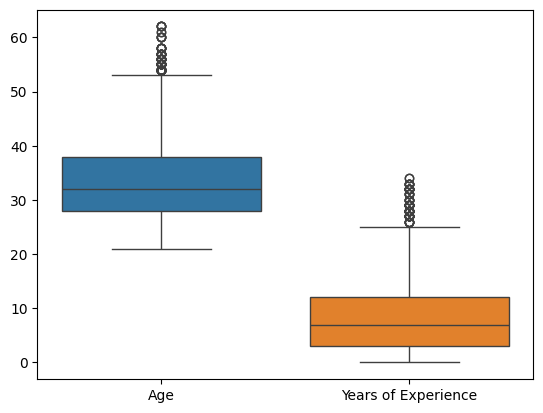

In [11]:
features = df.drop(columns=['Salary'])
sns.boxplot(data=features)

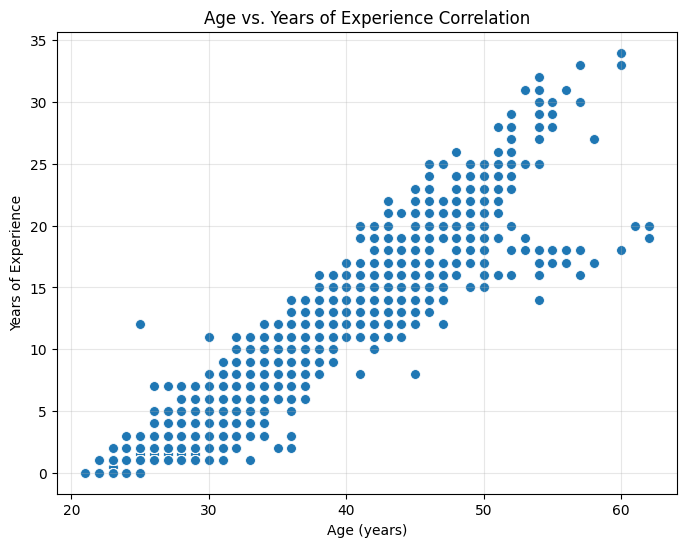

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['Years of Experience'], data=df, s=50)
plt.title('Age vs. Years of Experience Correlation')
plt.xlabel('Age (years)')
plt.ylabel('Years of Experience')
plt.grid(alpha=0.3)
plt.show()

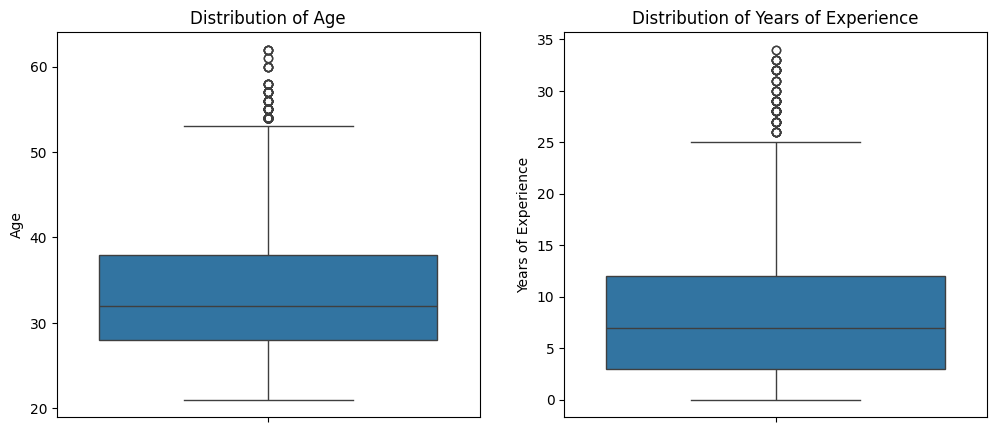

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(y=df['Age'], data=df, ax=ax[0])
ax[0].set_title('Distribution of Age')

sns.boxplot(y=df['Years of Experience'])
ax=ax[1].set_title('Distribution of Years of Experience')

plt.show()

                  variable  value
0                      Age   32.0
1                      Age   28.0
2                      Age   45.0
3                      Age   36.0
4                      Age   52.0
...                    ...    ...
13403  Years of Experience   20.0
13404  Years of Experience    3.0
13405  Years of Experience    4.0
13406  Years of Experience   14.0
13407  Years of Experience    1.0

[13408 rows x 2 columns]


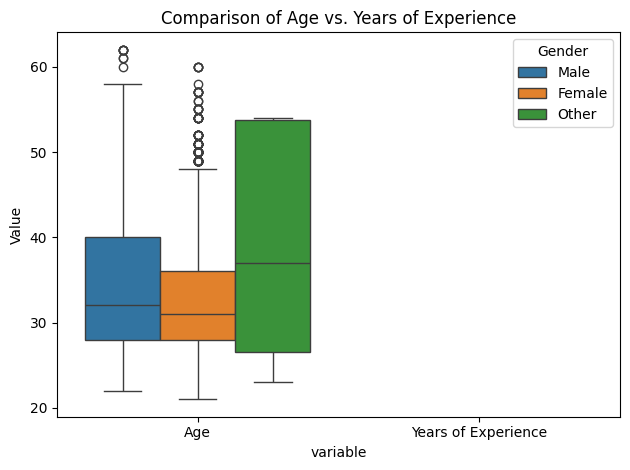

In [14]:
df_melted = pd.melt(df, value_vars=['Age', 'Years of Experience'])
print(df_melted)
sns.boxplot(x='variable', y='value', hue=df['Gender'], data=df_melted)
plt.title('Comparison of Age vs. Years of Experience')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [15]:
df['Gender'].value_counts()

Gender
Male      3674
Female    3014
Other       14
Name: count, dtype: int64

In [16]:
# Delete "other" from gender column 
df = df[df['Gender'].isin(['Male', 'Female'])]


In [17]:
df['Gender'].value_counts()

Gender
Male      3674
Female    3014
Name: count, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split


def clean_split_data(df, target_col='Salary'):
      # Drop rows where target is missing (or impute if appropriate)
    df[target_col] = df[target_col].fillna(df[target_col].median())

    # sparate features and target 
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return X, y

def preprocessing_data(df,  model,target_col='Salary'): 

    # create preprocessing pipline 
    preprocessor  = ColumnTransformer(
        transformers=[
             ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), ['Gender', 'Education Level', 'Job Title']),
            # scale numerical features
            ('mumerical', Pipeline([
            ('imputer', SimpleImputer(strategy='median')), 
                ('scaler', StandardScaler())

            ]), ['Age', 'Years of Experience'])

])

    # create pipeline 
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    X, y = clean_split_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train the model
    pipeline.fit(X_train, y_train)

    # evaluate the model
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, test_pred)

    print(f"MSE: {mse:.4f}")
    print(f"Train R²: {r2_score(y_train, train_pred):.3f}")
    print(f"Test R²: {r2_score(y_test, test_pred):.3f}")

    joblib.dump(pipeline, 'salary_model.pkl')


In [33]:
print("Training using SVR")
svr =  preprocessing_data(df, model=SVR(kernel='linear', C=100, epsilon=0.5))
print("Training using Ridge")
ridge = preprocessing_data(df, model=Ridge())
print("Training using Lasso")
lasso = preprocessing_data(df, model=Lasso())


Training using SVR
MSE: 702711599.9569
Train R²: 0.746
Test R²: 0.745
Training using Ridge
MSE: 465332654.0923
Train R²: 0.843
Test R²: 0.831
Training using Lasso
MSE: 465257939.5996
Train R²: 0.844
Test R²: 0.831


### Ridge<br>
MSE: 465332654.0923<br>
Train R²: 0.843<br>
Test R²: 0.831<br>
### Lasso<br>
MSE: 465257939.5996<br>
Train R²: 0.844<br>
Test R²: 0.831<br>
### Normal linear regression<br> 
MSE: 465913298.4694<br>
Train R²: 0.844<br>
Test R²: 0.831<br>

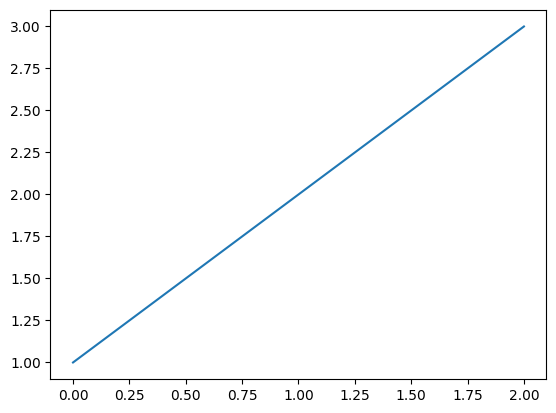

In [ ]:
x = np.array([1,2,3])
y = [4,5,6]
plt.plot(x)